## Analysis and Comparision of Beliefs across the Ops

In [1]:
from polygraphs.analysis import Processor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest

/Users/prudhvivuda/Documents/polygraphs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
processor = Processor(["../../CollegeMSG/"], config_check=False)
processor.add_config("reliability")

In [3]:
# Collect Belief Data
beliefs = pd.DataFrame()

for sim in processor.sims.iterrows():
    _ = processor.beliefs[sim[0]].copy()
    _["sim"] = sim[0]
    _["op"] = sim[1].op
    _["reliability"] = sim[1].reliability
    beliefs = pd.concat([beliefs, _])

In [4]:
# Aggregate Beliefs at Graph Level 
aggregated_beliefs = (
    beliefs.groupby(["op", "iteration"])
    .agg(
        mean_beliefs=("beliefs", "mean"),
        median_beliefs=("beliefs", "median"),
        std_beliefs=("beliefs", "std"),
        min_beliefs=("beliefs", "min"),
        max_beliefs=("beliefs", "max"),
        p25_beliefs=("beliefs", lambda x: x.quantile(0.25)),
        p75_beliefs=("beliefs", lambda x: x.quantile(0.75))
    )
    .reset_index()
)

In [5]:
aggregated_beliefs

,op,iteration,mean_beliefs,median_beliefs,std_beliefs,min_beliefs,max_beliefs,p25_beliefs,p75_beliefs
0,BalaGoyalOp,0,0.499387,0.499329,0.288417,0.000006,0.999983,0.249098,0.749464
1,BalaGoyalOp,1,0.500675,0.500917,0.290203,0.000008,0.999982,0.247771,0.75425
2,BalaGoyalOp,49,0.998431,0.998926,0.001763,0.992498,0.999751,0.997864,0.999509
3,BalaGoyalOp,64,0.998617,0.99973,0.002245,0.99286,0.99996,0.998782,0.999799
4,BalaGoyalOp,73,0.999092,0.999443,0.000961,0.996685,0.999981,0.998341,0.999925
...,...,...,...,...,...,...,...,...,...
1512,UnreliableNetworkModifiedAlignedNegativeEpsOp,24600,0.795627,0.999981,0.352806,0.0,1.0,0.743797,1.0
1513,UnreliableNetworkModifiedAlignedNegativeEpsOp,24700,0.795372,0.999982,0.352971,0.0,1.0,0.744057,1.0
1514,UnreliableNetworkModifiedAlignedNegativeEpsOp,24800,0.797065,0.999983,0.35166,0.0,1.0,0.751271,1.0
1515,UnreliableNetworkModifiedAlignedNegativeEpsOp,24900,0.798718,0.999984,0.350696,0.0,1.0,0.76042,1.0


In [6]:
ops = aggregated_beliefs["op"].unique()
results = pd.DataFrame()

for idx, op in enumerate(ops):
    for other_op in ops[idx + 1:]:
        # Compare distributions of mean beliefs
        test_result = kstest(
            aggregated_beliefs[aggregated_beliefs["op"] == op]["mean_beliefs"],
            aggregated_beliefs[aggregated_beliefs["op"] == other_op]["mean_beliefs"]
        )
        # Store results
        results = pd.concat([
            results,
            pd.DataFrame({
                "comparison": [f"{op} vs {other_op}"],
                "statistic": test_result.statistic,
                "pvalue": test_result.pvalue
            })
        ])

pd.options.display.float_format = "{:,.4f}".format
print(results.set_index("comparison"))

                                                    statistic  pvalue
comparison                                                           
BalaGoyalOp vs UnreliableNetworkBasicGullibleBi...     0.6770  0.0000
BalaGoyalOp vs UnreliableNetworkBasicGullibleNe...     0.9105  0.0000
BalaGoyalOp vs UnreliableNetworkIdealOp                0.6420  0.0000
BalaGoyalOp vs UnreliableNetworkModifiedAligned...     0.7665  0.0000
BalaGoyalOp vs UnreliableNetworkModifiedAligned...     0.9300  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.8452  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.3095  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.4960  0.0000
UnreliableNetworkBasicGullibleBinomialOp vs Unr...     0.8849  0.0000
UnreliableNetworkBasicGullibleNegativeEpsOp vs ...     0.8730  0.0000
UnreliableNetworkBasicGullibleNegativeEpsOp vs ...     0.7222  0.0000
UnreliableNetworkBasicGullibleNegativeEpsOp vs ...     0.6111  0.0000
UnreliableNetworkIde

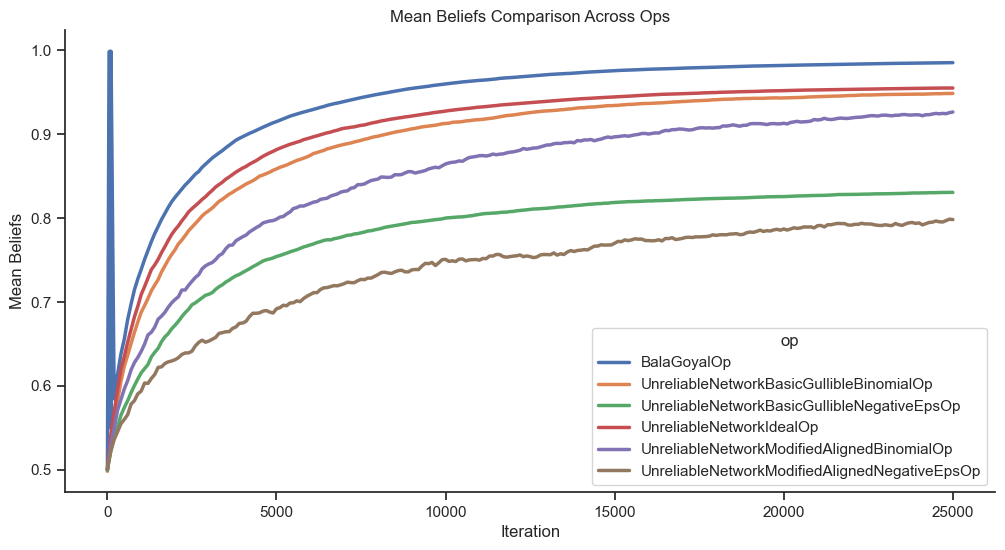

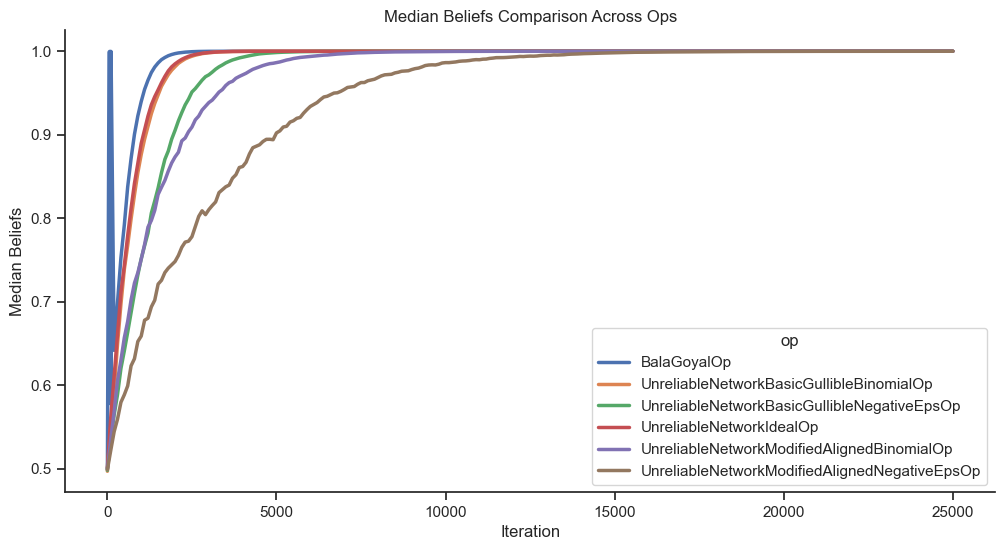

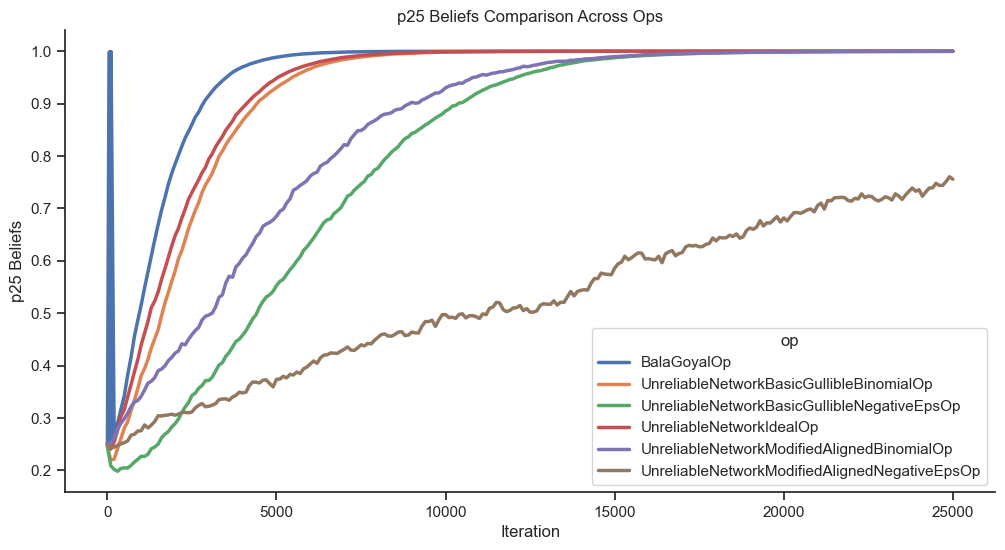

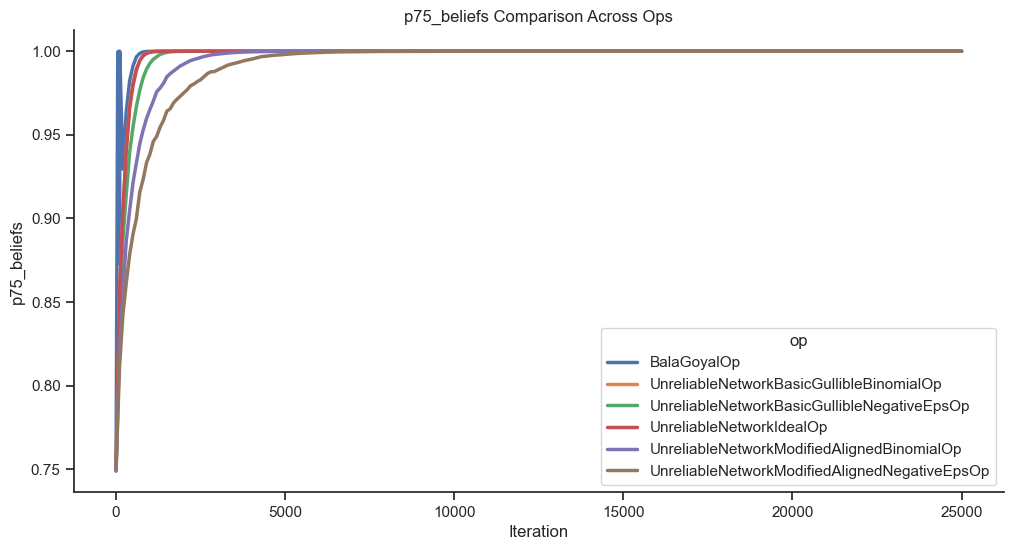

In [7]:
beliefs = {
    'mean_beliefs': 'Mean Beliefs', 
    'median_beliefs': 'Median Beliefs', 
    "p25_beliefs": 'p25 Beliefs', 
    "p75_beliefs": 'p75_beliefs'
}

for key, value in beliefs.items():
    sns.set_theme(style="ticks")
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=aggregated_beliefs,
                x="iteration",
                y=key,
                hue="op",
                lw=2.5)
    plt.title(f"{value} Comparison Across Ops")
    plt.ylabel(value)
    plt.xlabel("Iteration")
    sns.despine()
    plt.show()

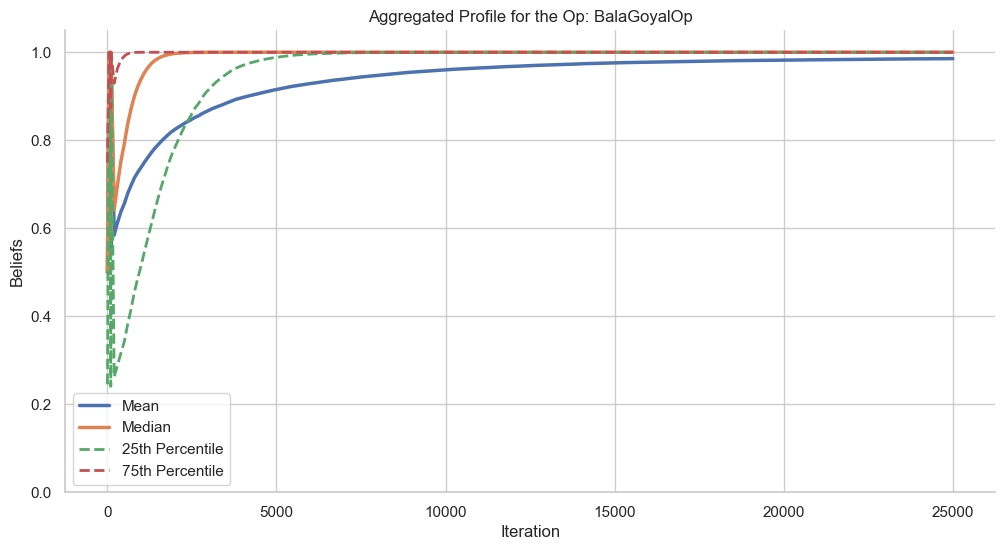

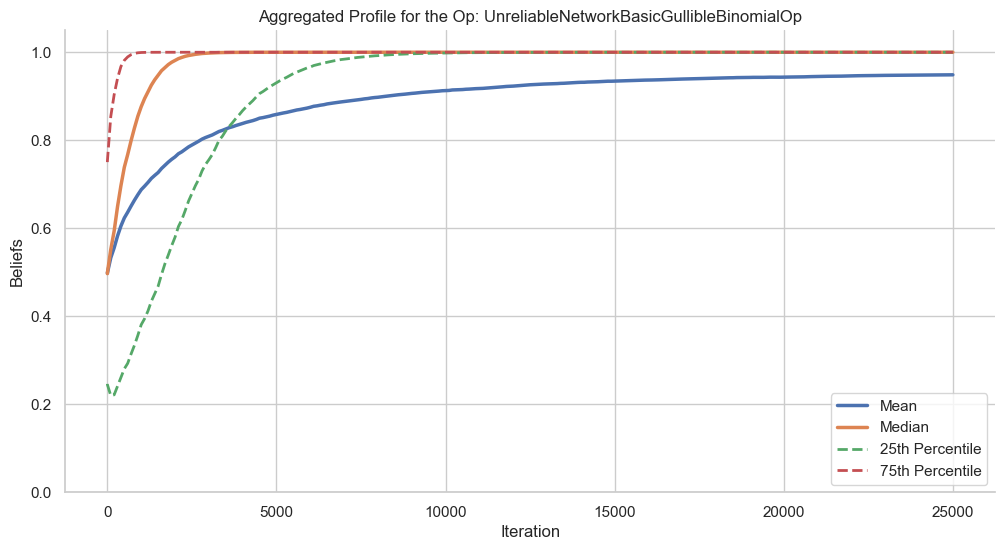

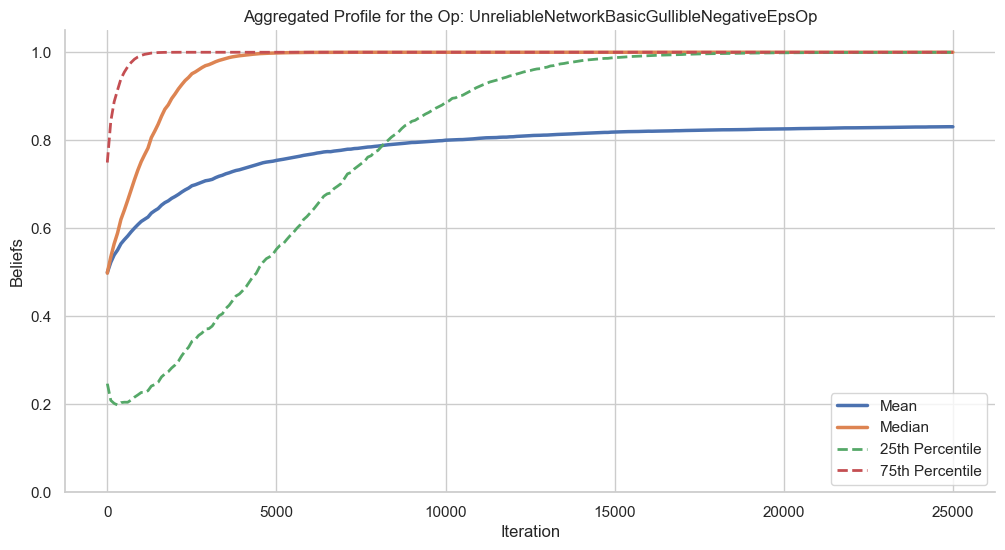

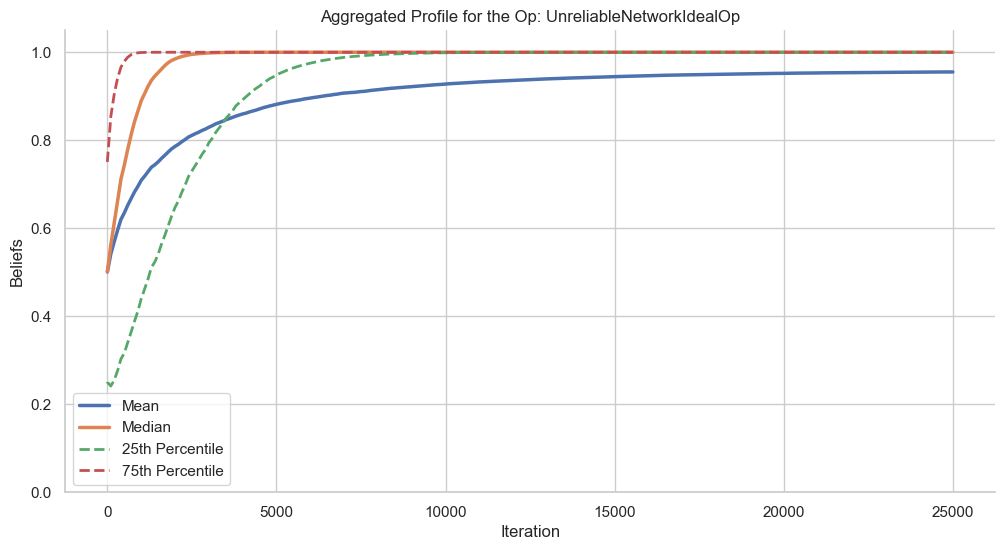

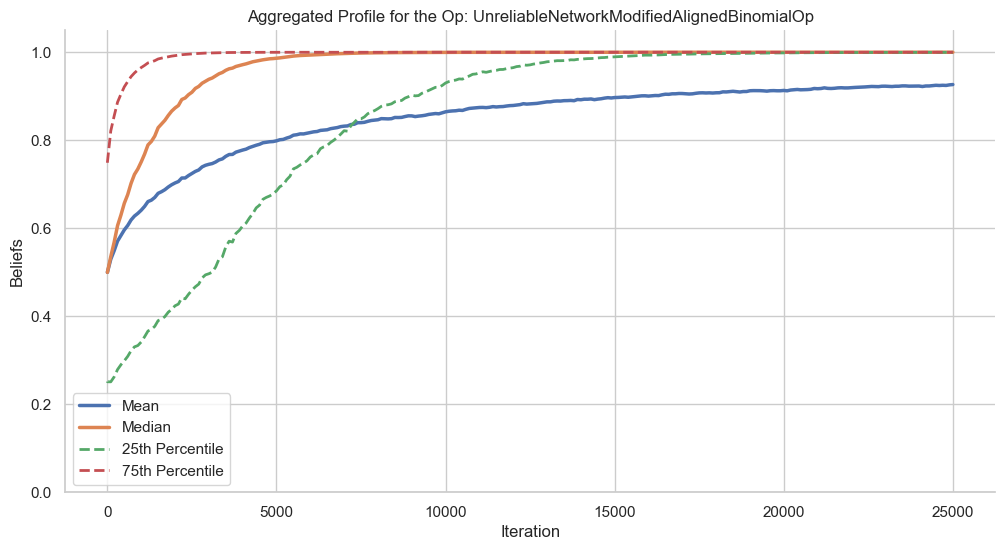

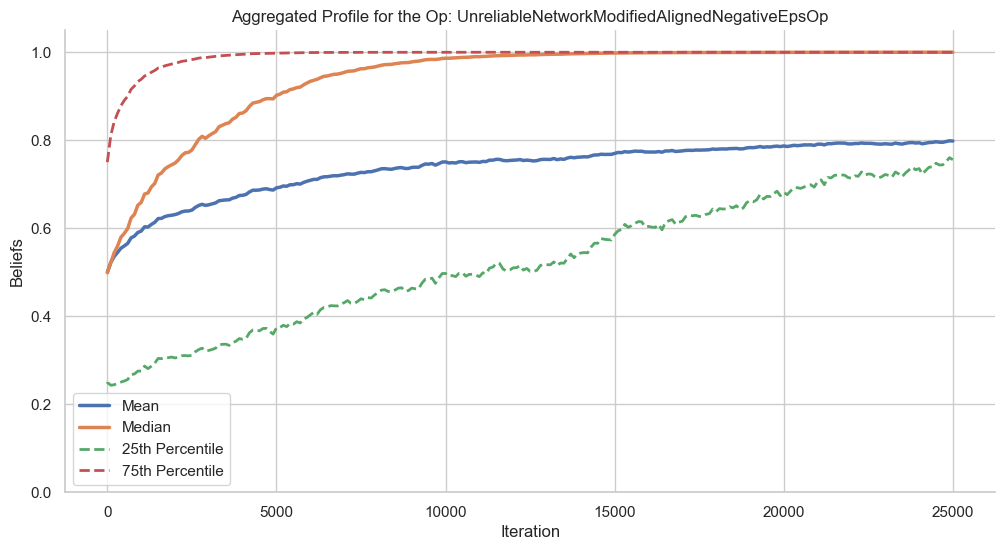

In [8]:
# Aggregated Profile for Each Operator
sns.set_theme(style="whitegrid")
unique_ops = aggregated_beliefs["op"].unique()

for op in unique_ops:
    op_data = aggregated_beliefs[aggregated_beliefs["op"] == op]
    
    plt.figure(figsize=(12, 6))
    plt.plot(op_data["iteration"], op_data["mean_beliefs"], label="Mean", lw=2.5)
    plt.plot(op_data["iteration"], op_data["median_beliefs"], label="Median", lw=2.5)
    plt.plot(op_data["iteration"], op_data["p25_beliefs"], label="25th Percentile", linestyle='--', lw=2)
    plt.plot(op_data["iteration"], op_data["p75_beliefs"], label="75th Percentile", linestyle='--', lw=2)
    # plt.plot(op_data["iteration"], op_data["min_beliefs"], label="Min", linestyle=':', lw=2)
    # plt.plot(op_data["iteration"], op_data["max_beliefs"], label="Max", linestyle=':', lw=2)
    
    plt.title(f"Aggregated Profile for the Op: {op}")
    plt.xlabel("Iteration")
    plt.ylabel("Beliefs")
    plt.ylim(0, 1.05)
    plt.legend()
    sns.despine()
    plt.show()
